### lightGBMでトレーニングしました。

Final Logloss with CV: 0.2094715771575293

In [1]:
from google.colab import drive

# Google Driveをマウント
drive.mount('/content/drive')

# マウント完了後のメッセージ
print("Google Driveがマウントされました！")

Mounted at /content/drive
Google Driveがマウントされました！


In [ ]:
import pandas as pd


# TSVファイルを読み込む
file_path = '/content/drive/My Drive/signate/train/train_0105.tsv'
train = pd.read_csv(file_path, low_memory=False, sep='\t')

train.info()

## パラメータを設定しモデルをトレーニングする

In [2]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss

# TSVファイルを読み込む
file_path = '/content/drive/My Drive/signate/train/train_0101.tsv'
train = pd.read_csv(file_path, low_memory=False, sep='\t')

# 新しい特徴量を作成
train['C2_I11_interaction'] = train['C2'] * train['I11']
train['I5_I12_I6_sum'] = train['I5'] + train['I12'] + train['I6']
train['C2_C3_C5_mean'] = (train['C2'] + train['C3'] + train['C5']) / 3
train['I_mean'] = (train['I11'] + train['I10'] + train['I5']) / 4


# 目的変数と特徴量を分ける前にカテゴリカル変数を追加
train['C2_C3_C5_mean_cat'] = train['C2_C3_C5_mean'].round().astype(int)

# 目的変数（ターゲット列）と特徴量を分ける
target_column = 'click'
X = train.drop(columns=[target_column, 'id'])
y = train[target_column]

# カテゴリカル変数リストの更新
categorical_features = ['C1', 'C4', 'C6', 'C2_freq_group', 'C3_freq_group', 'C5_freq_group', 'C2_C3_C5_mean_cat']

# 指定した特徴量をカテゴリ型に変換
for col in categorical_features:
    if col in X.columns:  # 特徴量リストに存在する場合のみ変換
        X[col] = X[col].astype('category')

# LightGBMパラメータ
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'max_depth': 10,
    'verbose': -1
}

# クロスバリデーションの設定
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=24)

logloss_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits}")

    # トレーニングデータと検証データの分割
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # データセットの作成
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=train_data)

    # モデルの学習
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(50)]
    )

    # 検証データの予測確率
    y_val_proba = model.predict(X_val)

    # Loglossを計算
    logloss = log_loss(y_val, y_val_proba)
    logloss_scores.append(logloss)

    print(f"Fold {fold + 1} Logloss: {logloss}")

# 平均Loglossスコア
mean_logloss = sum(logloss_scores) / len(logloss_scores)
print(f"\nMean Logloss across folds: {mean_logloss}")

# モデルを保存
model_file_path = '/content/drive/My Drive/signate/submission/lgbm_model_0105_1.txt'
model.save_model(model_file_path)
print(f"Model saved to: {model_file_path}")


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Fold 1/5
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.206518	valid's binary_logloss: 0.210017
[100]	train's binary_logloss: 0.202831	valid's binary_logloss: 0.20885
[150]	train's binary_logloss: 0.200382	valid's binary_logloss: 0.208539
[200]	train's binary_logloss: 0.198455	valid's binary_logloss: 0.208374
[250]	train's binary_logloss: 0.196929	valid's binary_logloss: 0.208369
[300]	train's binary_logloss: 0.195518	valid's binary_logloss: 0.208406
Early stopping, best iteration is:
[241]	train's binary_logloss: 0.197194	valid's binary_logloss: 0.208364
Fold 1 Logloss: 0.20836426510751618
Fold 2/5
Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.206273	valid's binary_logloss: 0.210685
[100]	train's binary_logloss: 0.202514	valid's binary_logloss: 0.209689
[150]	train's binary_logloss: 0.200148	valid's binary_logloss: 0.209578
[200]	train's binary_logloss: 0.198256	valid's binary_logloss: 0.20950

In [ ]:
train.head()

,id,click,I1,I2,C1,C2,C3,C4,C5,C6,...,C2_freq,C3_freq,C5_freq,C2_freq_group,C3_freq_group,C5_freq_group,C2_I11_interaction,I5_I12_I6_sum,shap_sum,shap_var
0,0,0,5,20,421256035,2377199148,2696211399,2298910535,3133252034,1509930964,...,0.005017,0.002353,0.002588,2,3,1,7.121452e+09,1.609439,2.826035,0.036596
1,1,0,5,20,2581703001,2589684548,1998340283,2411205997,3202148071,1238839469,...,0.123006,0.064278,0.019702,4,2,1,7.758002e+09,3.302585,0.887298,0.018730
2,2,0,5,20,2581703001,1862037199,2448089184,2411205997,1107442947,3668889797,...,0.222245,0.133608,0.000839,3,0,1,5.578165e+09,1.609439,-0.883863,0.011510
3,3,0,5,20,421256035,3874378935,1658216424,2298910535,2321672976,1509930964,...,0.257679,0.047051,0.343521,0,4,0,7.539193e+09,1.945911,1.061518,0.008415
4,4,1,5,20,421256035,3874378935,1892769125,2411205997,2321672976,1509930964,...,0.257679,0.136384,0.343521,0,0,0,2.685515e+09,3.465737,1.524499,0.015876


In [ ]:
# データセットの保存
train.to_csv('/content/drive/My Drive/signate/train/train_0105.csv', index=False)

## モデルが重視する特徴量を可視化し、loglossを計算する

Final Logloss with CV: 0.2094715771575293


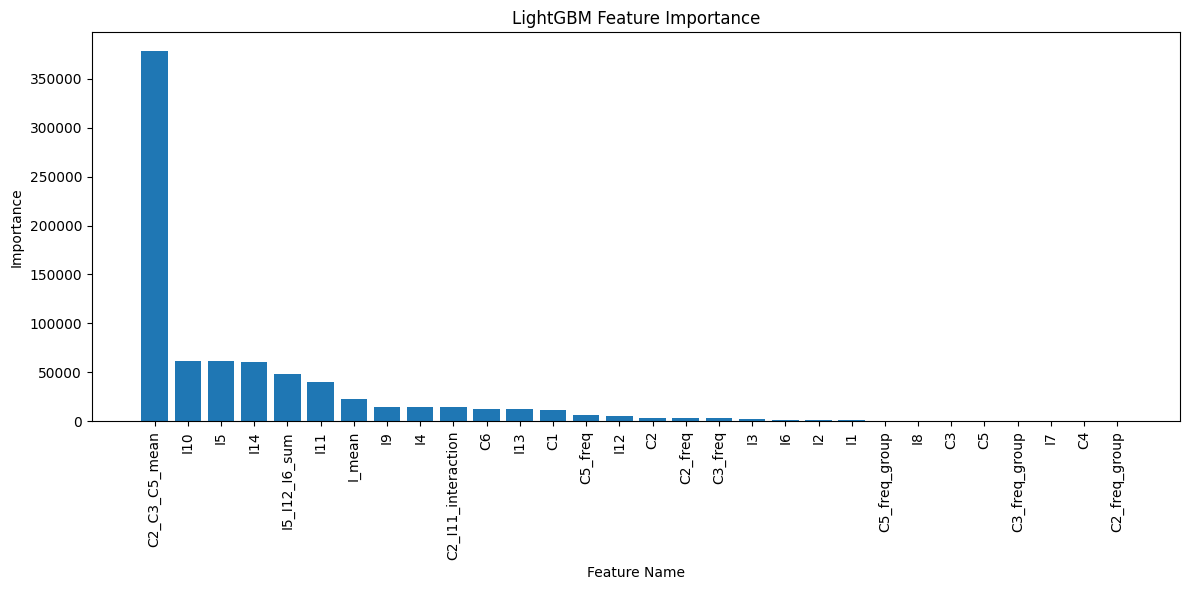

In [ ]:
import pandas as pd
import lightgbm as lgb
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt

# TSVファイルを読み込む
file_path = '/content/drive/My Drive/signate/train/train_0105.csv'
train = pd.read_csv(file_path, low_memory=False)

# 目的変数と特徴量の分離
target_column = 'click'
X = train.drop(columns=[target_column, 'id'])
y = train[target_column]

# カテゴリカル変数の指定
categorical_features = ['C1', 'C6','C3_freq_group', 'C2_C3_C5_mean']
for col in categorical_features:
    if col in X.columns:
        X[col] = X[col].astype('category')

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # モデルの学習
    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    lgb_model = lgb.train({'objective': 'binary', 'metric': 'logloss'}, lgb_train, num_boost_round=100)

    # 予測とログロスの計算
    oof_preds[val_idx] = lgb_model.predict(X_val)

# 最終評価
final_logloss = log_loss(y, oof_preds)
print(f"Final Logloss with CV: {final_logloss}")

# モデルの再学習 (全データ使用)
lgb_train_final = lgb.Dataset(X, label=y, categorical_feature=categorical_features)
lgb_model_final = lgb.train({'objective': 'binary', 'metric': 'logloss'}, lgb_train_final, num_boost_round=100)

# 特徴量重要度の可視化
feature_importances = lgb_model_final.feature_importance(importance_type='gain')
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()
